# Water Quality Model

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pickle

## dataset

In [62]:
# importing the dataset
data = pd.read_csv("../dataset/water_data.csv")
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [63]:
data.shape

(3276, 10)

In [64]:
# checking potability distr
data["Potability"].value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

In [65]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [67]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [68]:
data.duplicated().sum()

np.int64(0)

### cleaning the data

In [69]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [70]:
# mean and median for the sulfate entry
print(
    data["Sulfate"].median(),
    data["Sulfate"].mean()
)

333.073545745888 333.7757766108135


In [71]:
# mean and median for the ph entry
print(
    data["ph"].median(),
    data["ph"].mean()
)

7.036752103833548 7.080794504276835


In [72]:
# mean and median for trihalomethanes entry
print(
    data["Trihalomethanes"].median(),
    data["Trihalomethanes"].mean()
)

66.62248509808484 66.39629294676803


In [73]:
# filling the missing values with the means
cols_with_na = data.columns[data.isnull().any()].tolist()
cols_with_na

['ph', 'Sulfate', 'Trihalomethanes']

In [74]:
# filling with means
for column in cols_with_na:
    data[column] = data[column].fillna(data[column].mean())

data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [75]:
data.shape

(3276, 10)

In [76]:
data.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,7.080795,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


## exploratory data analysis

In [77]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.469956,32.879761,8768.570828,1.583085,36.142612,80.824064,3.308162,15.769881,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.080795,196.967627,20927.833607,7.130299,333.775777,421.884968,14.218338,66.396293,3.955028,0.000000
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


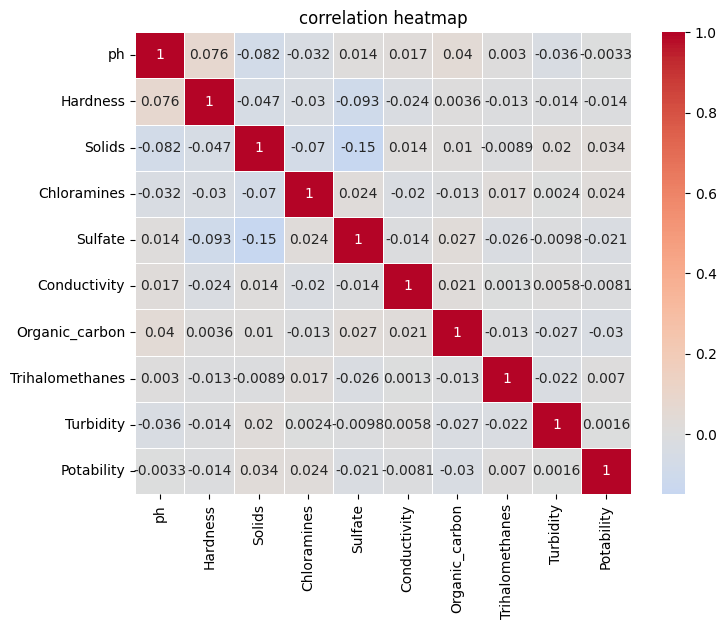

In [78]:
# correlation matrix heatmap
corr_matrix = data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("correlation heatmap")
plt.show()

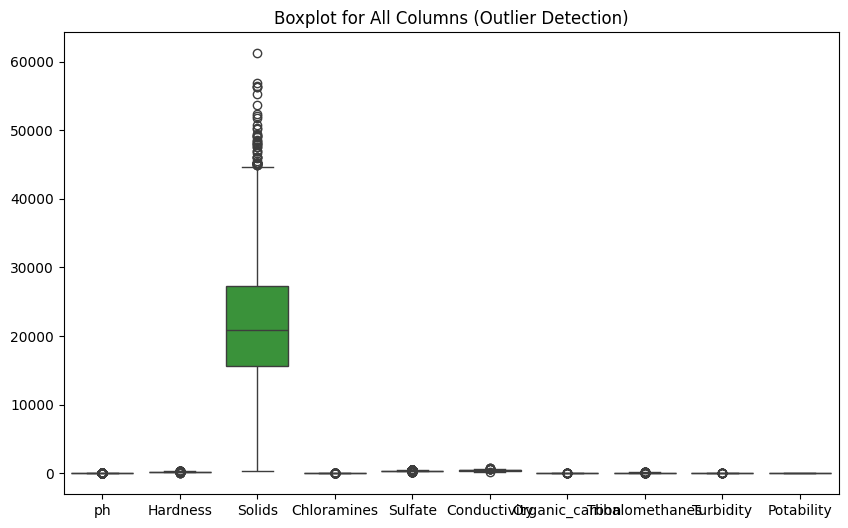

In [79]:
# outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=data, orient="v")
plt.title("Boxplot for All Columns (Outlier Detection)")
plt.show()


In [80]:
# boxplot function
def features_boxplots(data, feature):
    plt.figure(figsize=(6,4))
    sns.boxplot(y=data[feature])
    plt.title(f"boxplot for {feature}")
    plt.show()

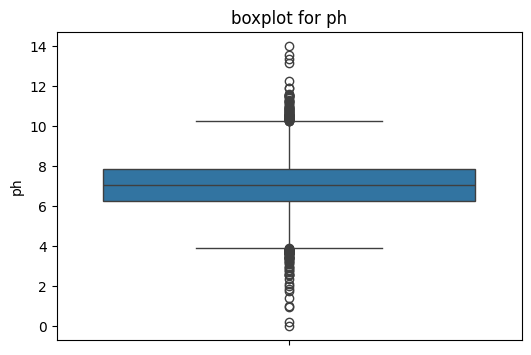

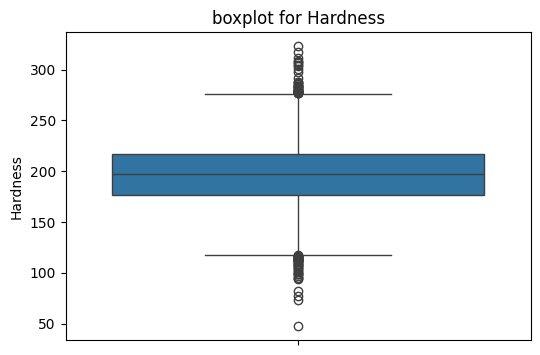

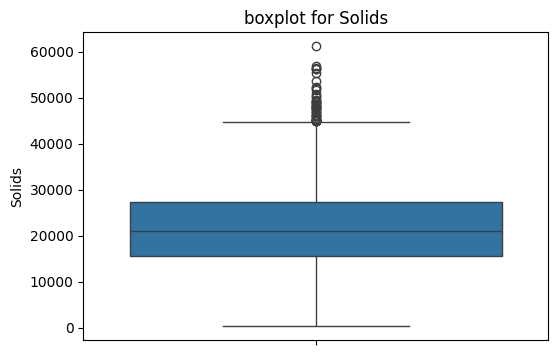

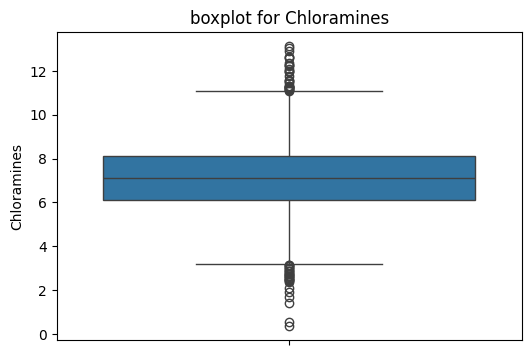

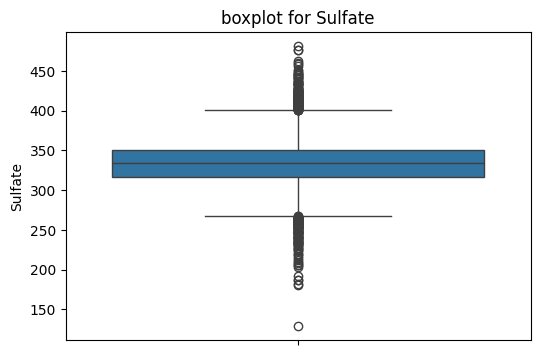

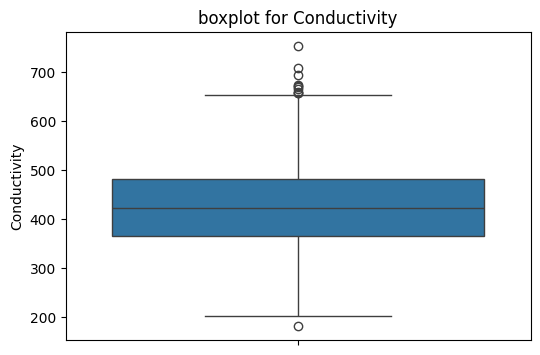

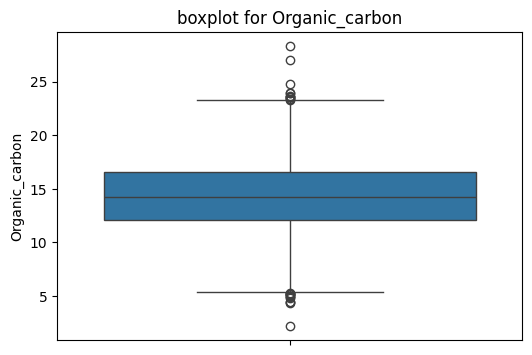

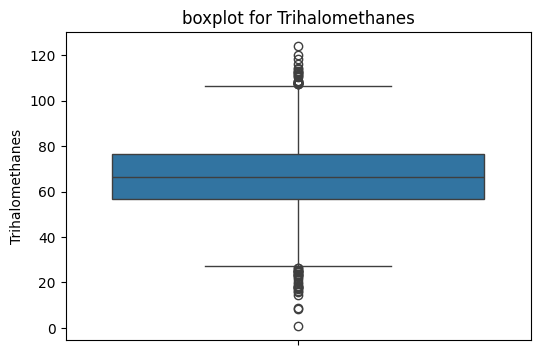

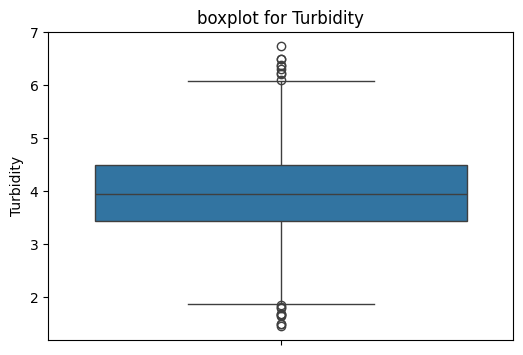

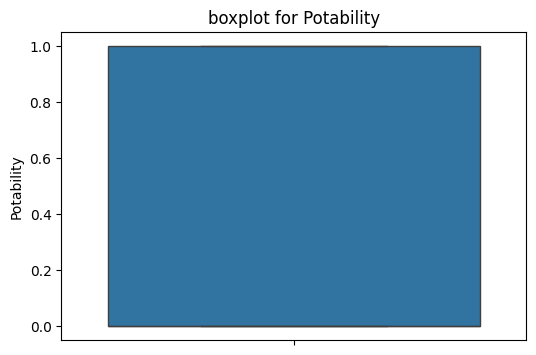

In [81]:
# indivindual features boxplots
features = data.columns.tolist()
for feature in features:
    features_boxplots(data, feature)

In [82]:
# function to get outliers
def get_outliers(data):
    outlier_dict = {}
    features = data.drop("Potability", axis=1).columns.tolist()
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = data[
            (data[feature] < lower) |
            (data[feature] > upper)
        ][feature]
        outlier_dict[feature] = outliers.tolist()
    return outlier_dict

In [83]:
# getting outliers
outliers = get_outliers(data)
print("outliers:\n", len(outliers))
print("\n")

# outliers per column
for feature, outs in outliers.items():
    print(
        feature, "outliers:\n", outs if outs else "None"
    )
    print(len(outs))
    print("-"*50)

outliers:
 9


ph outliers:
 [3.71608007538699, 11.180284470721592, 3.4450618643852127, 10.43329098280438, 3.641629777473381, 10.68296642580598, 10.560744636218196, 3.514545528745279, 3.72250048593372, 1.844538366498842, 2.612035914817261, 3.388090610523891, 10.308477656813704, 11.180694664461903, 3.719791644371925, 11.26782838471403, 3.664710561719395, 13.175401724233025, 10.761897799889317, 10.356118827208377, 3.882631081313793, 11.301793996392291, 3.657123132566738, 3.551579176967154, 2.798549098862777, 10.272444272154384, 10.46450247726032, 10.316400384553162, 3.841205038045167, 3.41035967073924, 10.509668629307154, 3.623165848258656, 1.757037115490783, 3.681076270548827, 3.633162828862528, 10.26843050116335, 0.2274990502021987, 3.4264503676355647, 10.53809844277246, 11.89807802974039, 10.268414718941344, 10.90507641006552, 0.9899122128791388, 10.695532491586295, 10.632909606071516, 10.282067974894762, 10.678056255643256, 10.386132934434618, 10.811289500397242, 10.581385987628256, 

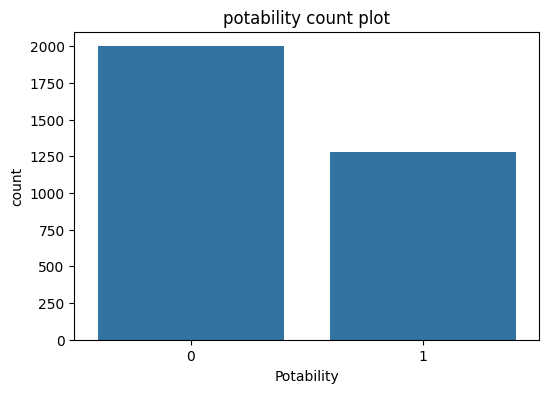

In [84]:
# potability countplot
plt.figure(figsize=(6, 4))
sns.countplot(x="Potability", data=data)
plt.title("potability count plot")
plt.show()

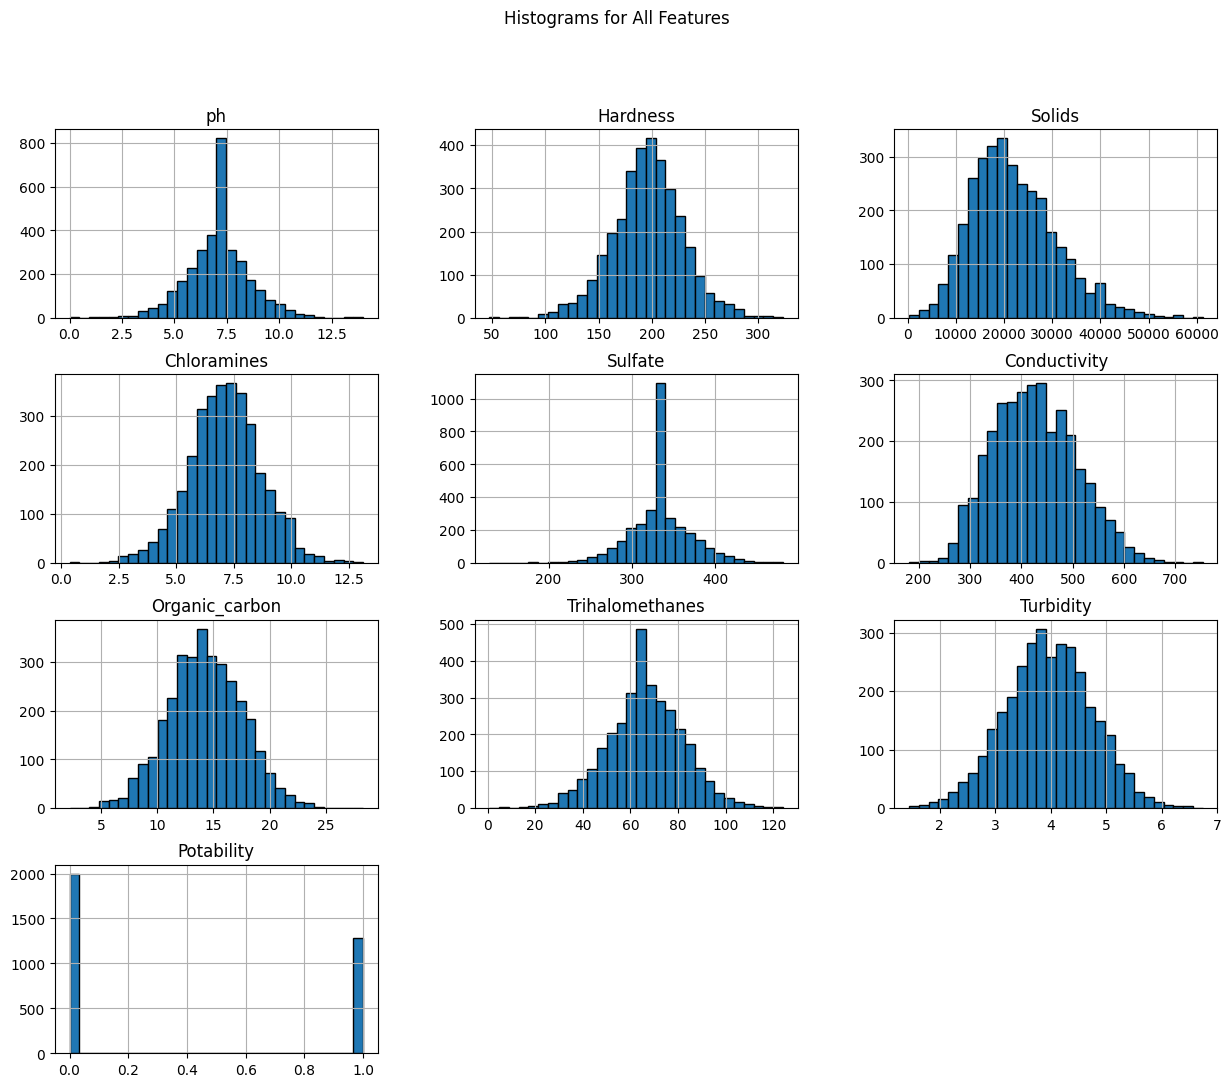

In [85]:
# histogram analysis
data.hist(figsize=(15, 12), bins=30, edgecolor="black")
plt.suptitle("Histograms for All Features")
plt.show()

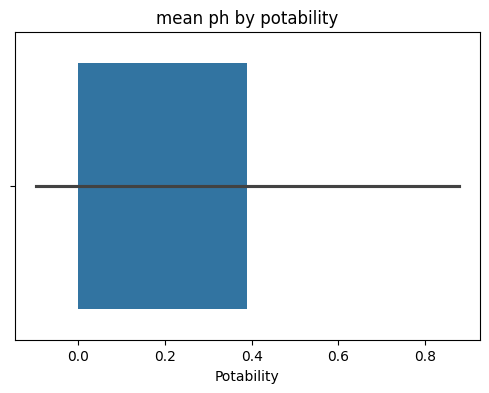

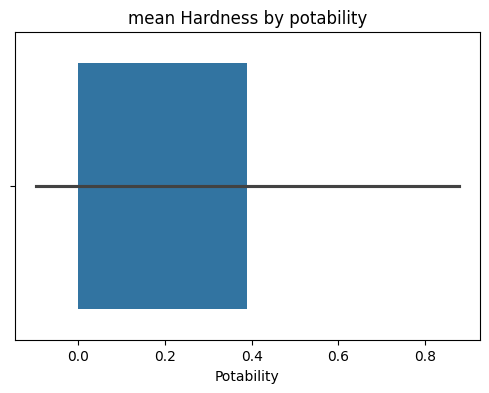

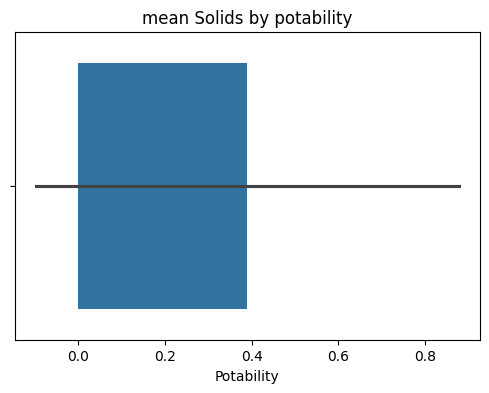

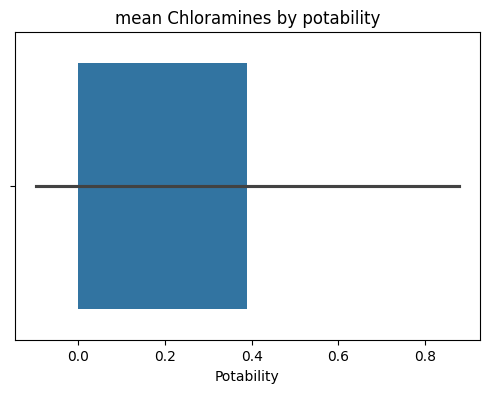

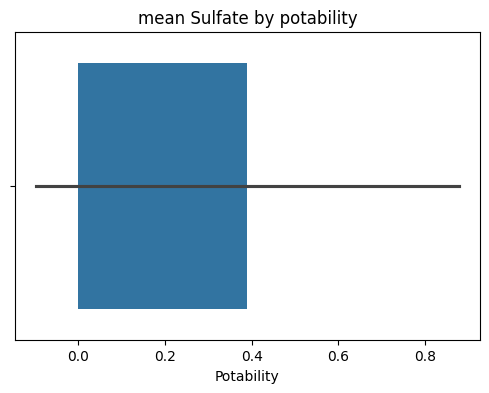

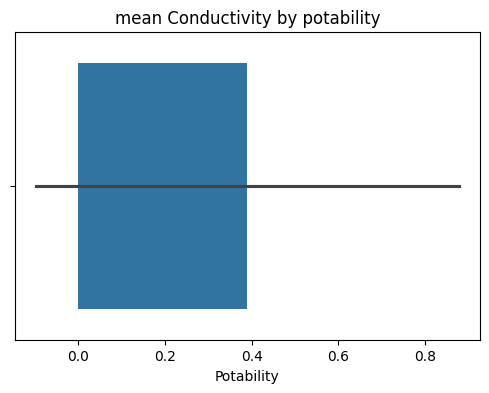

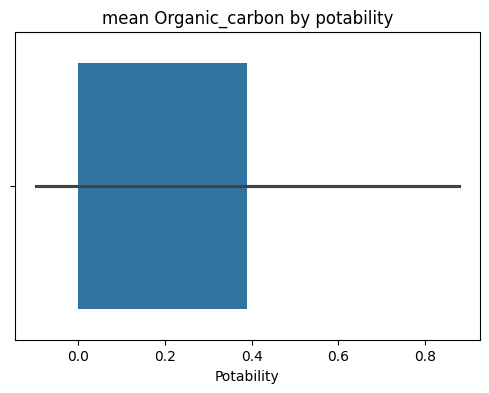

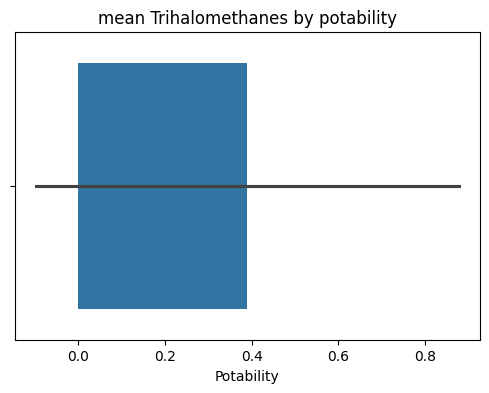

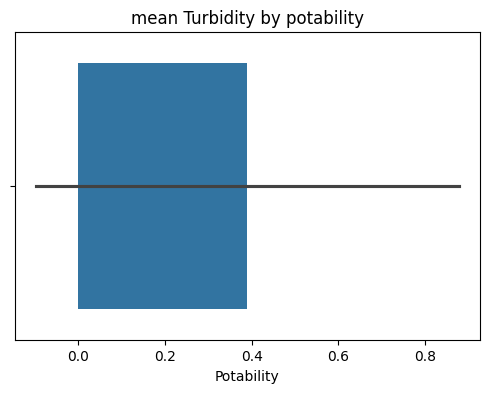

In [86]:
features = data.drop("Potability", axis=1).columns.tolist()
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.barplot(
        x="Potability",
        data=data,
        estimator="mean",
        errorbar="sd"
    )
    plt.title(f"mean {feature} by potability")
    plt.show()

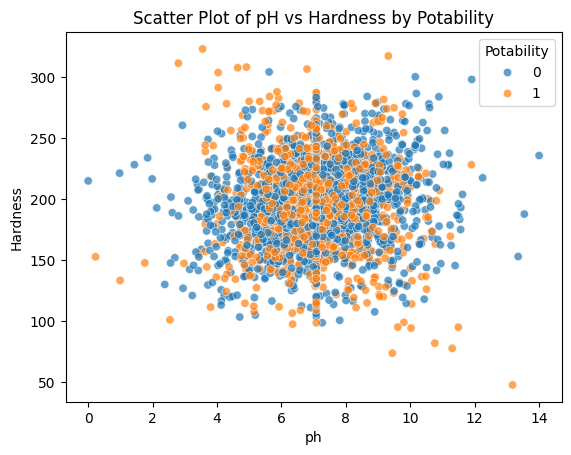

In [87]:

# scatter plot
sns.scatterplot(x="ph", y="Hardness", hue="Potability", data=data, alpha=0.7)
plt.title("Scatter Plot of pH vs Hardness by Potability")
plt.show()

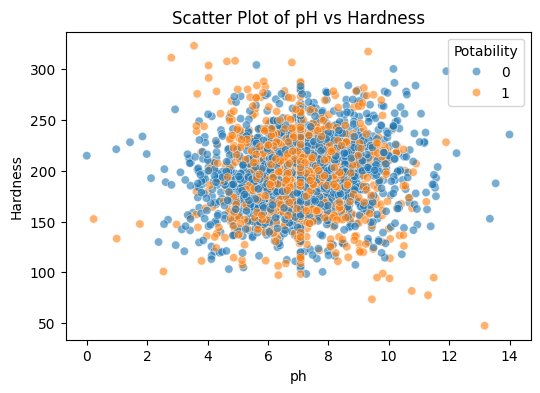

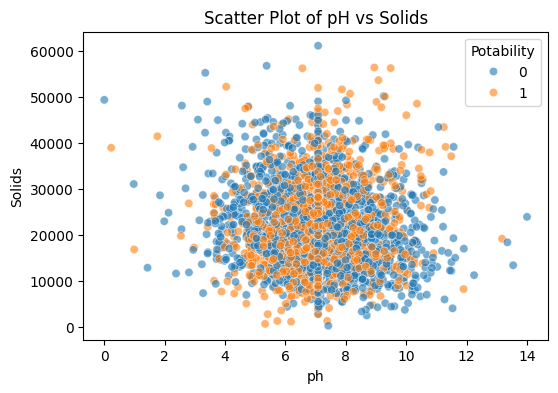

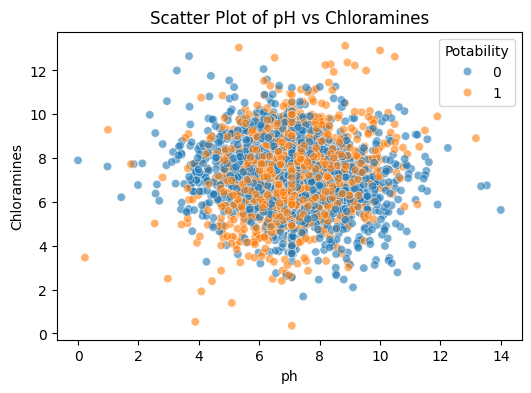

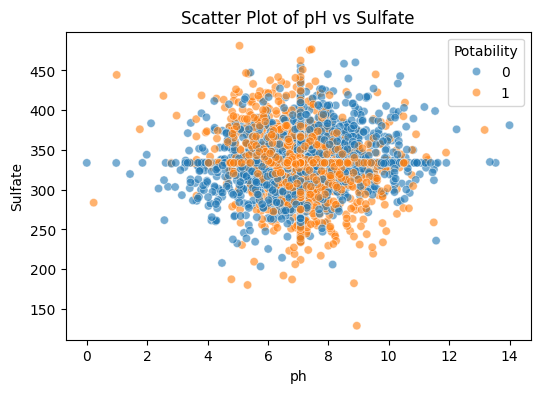

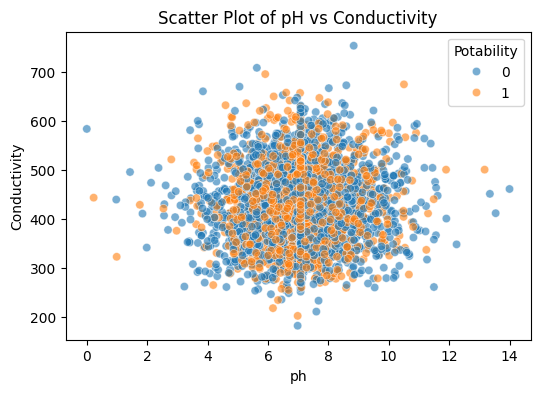

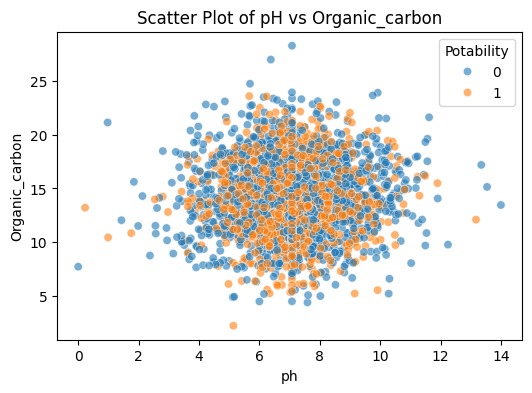

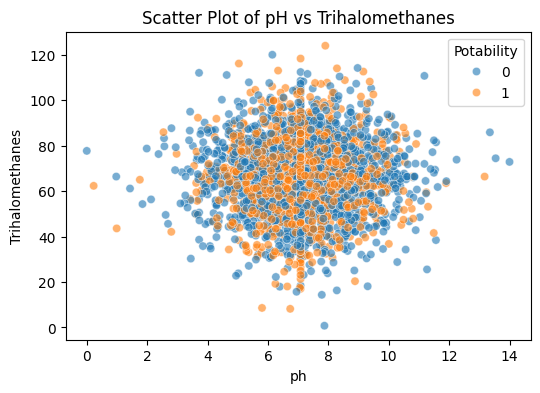

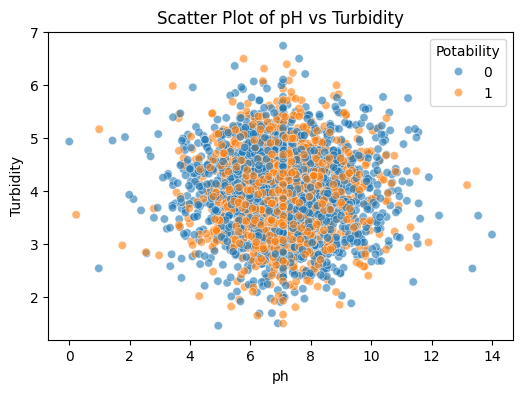

In [88]:
for feature in features:
    if feature != "ph":
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x="ph", y=feature, hue="Potability", data=data, alpha=0.6)
        plt.title(f"Scatter Plot of pH vs {feature}")
        plt.show()


## preprocessing

### capping outliers

In [117]:
# dealing with the outliers function using capping (whisker replacement)
def cap_outliers_iqr(data, cols=None, factor=1.5):

    data_capped = data.copy()
    if cols is None:
        cols = data.columns.tolist()
    
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # replace values beyond whiskers
        data_capped[col] = np.where(data[col] < lower_bound, lower_bound,
                          np.where(data[col] > upper_bound, upper_bound, data[col]))
    
    return data_capped


In [122]:
# whisker replacement
data_capped = cap_outliers_iqr(data)

# Verify changes on one column
print("Before capping:")
print(data['Sulfate'].describe())

print("\nAfter capping:")
print(data_capped['Sulfate'].describe())


Before capping:
count    3276.000000
mean      333.775777
std        36.142612
min       129.000000
25%       317.094638
50%       333.775777
75%       350.385756
max       481.030642
Name: Sulfate, dtype: float64

After capping:
count    3276.000000
mean      333.788678
std        31.768004
min       267.157960
25%       317.094638
50%       333.775777
75%       350.385756
max       400.322434
Name: Sulfate, dtype: float64


In [119]:
data_capped.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [113]:
# seeing of outliers now
outliers = get_outliers(data_capped)
for feature, outs in outliers.items():
    print(
        feature, "outliers:\n", outs if outs else "None"
    )
    print(len(outs))
    print("-"*50)

ph outliers:
 None
0
--------------------------------------------------
Hardness outliers:
 None
0
--------------------------------------------------
Solids outliers:
 None
0
--------------------------------------------------
Chloramines outliers:
 None
0
--------------------------------------------------
Sulfate outliers:
 None
0
--------------------------------------------------
Conductivity outliers:
 None
0
--------------------------------------------------
Organic_carbon outliers:
 None
0
--------------------------------------------------
Trihalomethanes outliers:
 None
0
--------------------------------------------------
Turbidity outliers:
 None
0
--------------------------------------------------


In [89]:
# feature and labels selection
features, target = data.drop("Potability", axis=1), data["Potability"]
print(features.shape, target.shape)

(3276, 9) (3276,)


In [90]:
features

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075
...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821
3272,7.808856,193.553212,17329.802160,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243
3273,9.419510,175.762646,33155.578218,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875
3274,5.126763,230.603758,11983.869376,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658


In [91]:
target

0       0
1       0
2       0
3       0
4       0
       ..
3271    1
3272    1
3273    1
3274    1
3275    1
Name: Potability, Length: 3276, dtype: int64

In [ ]:
# original data train test split
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size = 0.2,
    stratify = target,
    random_state = 42,
)
print(features.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3276, 9) (2620, 9) (656, 9) (2620,) (656,)


In [130]:
# original data resampling
smote = SMOTE(random_state=21)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [133]:
# scaling original data for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.51925212,  0.37396679,  0.04224658, ...,  0.58035951,
        -0.37321793, -0.18862721],
       [-0.73387062,  0.94346077, -1.00911153, ..., -2.23634414,
        -1.63106177, -0.50743971],
       [ 0.95640947,  0.98954914,  0.79328241, ...,  0.08613086,
        -0.35892247,  0.55893452],
       ...,
       [-1.10662298,  0.24628477, -0.36811092, ...,  0.18851661,
         1.19505189, -0.38335972],
       [-0.25650092,  0.13095247,  0.25191747, ...,  0.8947599 ,
        -0.26250327, -0.74312083],
       [ 0.07792799, -0.19362496,  0.49913048, ...,  1.33902104,
         0.5155921 ,  0.06423624]], shape=(3196, 9))

In [127]:
# splitting data_capped data
X, y = data_capped.drop("Potability", axis=1), data_capped["Potability"]

# train test split
X_train_capped, X_test_capped, y_train_capped, y_test_capped = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = y,
    random_state = 42,
)
print(X.shape, X_train_capped.shape, X_test_capped.shape, y_train_capped.shape, y_test_capped.shape)

(3276, 9) (2620, 9) (656, 9) (2620,) (656,)


In [135]:
# capped data resampling
smote = SMOTE(random_state=21)
X_cap_res, y_cap_res = smote.fit_resample(X_train_capped, y_train_capped)

In [137]:
# scaling the capped data for logistic regression
scaler = StandardScaler()
X_cap_train_scaled = scaler.fit_transform(X_cap_res)
X_cap_test_scaled = scaler.transform(X_test_capped)
X_cap_train_scaled.shape

(3196, 9)

### Remarks so far:
    i have three datasets namely:
        data - original data with outliers (used for benchmarking)
        data_capped - outliers removed (used for tuning and benchmarking comparisons perfomance with original)
        data with resampling (smote oversampling) - derived from original and class balanced using smote:
            X_res, y_res = smote.fit_resample(X_train, y_train)
        data_capped with resampling - as above except smote was applied on capped_data:
            X_cap_res, y_cap_res = smote.fit_resample(X_train_capped, y_train_capped)
        scaled data (will be used for logistic regression):
            scaled original data:
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled
            scaled data_capped
                X_cap_train_scaled =scaler.transform(X_test)
                X_cap_test_scaled



In [ ]:
# all data variations
print("Original data:\n", data.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Capped data:\n", data_capped.shape, X_train_capped.shape, X_test_capped.shape, y_train_capped.shape, y_test_capped.shape)
print("Original data oversampled:\n", X_res.shape, y_res.shape)
print("Capped data resampled:\n", X_cap_res.shape, y_cap_res.shape)
print("Original data scaled:\n", X_train_scaled.shape, X_test_scaled.shape)
print("Capped data scaled:\n", X_cap_train_scaled.shape, X_cap_test_scaled.shape)

Original data:
 (3276, 10) (2620, 9) (656, 9) (2620,) (656,)
Capped data:
 (3276, 10) (2620, 9) (656, 9) (2620,) (656,)
Original data oversampled:
 (3196, 9) (3196,)
Capped data resampled:
 (3196, 9) (3196,)
Original data scaled:
 (3196, 9) (656, 9)
Capped data scaled:
 (3196, 9) (656, 9)


## model building, training and optimization

###  random forest model

In [93]:
# building the model
rf_model = RandomForestClassifier(
    n_estimators = 500,
    max_depth = 10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs = -1,
    random_state = 21
)

In [94]:
# training the model
rf_model.fit(
    X_train,
    y_train
)

,n_estimators,500
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [95]:
# model evaluation
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(
    y_test, rf_preds
)
rf_clf_report = classification_report(
    y_test,
    rf_preds
)
print("random forest accuracy:\n", rf_acc)
print("-"*50)
print("random forest classification report:\n", rf_clf_report)

random forest accuracy:
 0.6600609756097561
--------------------------------------------------
random forest classification report:
               precision    recall  f1-score   support

           0       0.65      0.94      0.77       400
           1       0.71      0.21      0.33       256

    accuracy                           0.66       656
   macro avg       0.68      0.58      0.55       656
weighted avg       0.68      0.66      0.60       656



### catboost model

In [96]:
# building the model
cat_model = CatBoostClassifier(
    iterations = 500,
    depth = 8,
    learning_rate = 0.05,
    l2_leaf_reg = 3,
    verbose = 0,
    random_state = 21
)

In [97]:
# training the model
cat_model.fit(
    X_train,
    y_train
)

In [98]:
# model evaluation
cat_preds = cat_model.predict(X_test)
cat_acc = accuracy_score(
    y_test, cat_preds
)
cat_clf_report = classification_report(
    y_test,
    cat_preds
)
print("cat boost accuracy:\n", cat_acc)
print("-"*50)
print("cat boost classification report:\n", cat_clf_report)

cat boost accuracy:
 0.6554878048780488
--------------------------------------------------
cat boost classification report:
               precision    recall  f1-score   support

           0       0.67      0.84      0.75       400
           1       0.60      0.36      0.45       256

    accuracy                           0.66       656
   macro avg       0.64      0.60      0.60       656
weighted avg       0.64      0.66      0.63       656



### xgbclassifier model

In [99]:
# building the model
xgb_model = XGBClassifier(
    n_estimators = 500,
    learning_rate = 0.05,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 1,
    gamma = 0,
    use_label_encoder = False,
    eval_metric = "logloss"
)

In [100]:
# training the model
xgb_model.fit(
    X_train,
    y_train
)

/home/kami/miniconda3/envs/std-prog/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:34:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [101]:
# model evaluation
xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(
    y_test, xgb_preds
)
xgb_clf_report = classification_report(
    y_test,
    xgb_preds
)
print("xgb classifier accuracy:\n", xgb_acc)
print("-"*50)
print("xgb classifier classification report:\n", xgb_clf_report)

xgb classifier accuracy:
 0.6280487804878049
--------------------------------------------------
xgb classifier classification report:
               precision    recall  f1-score   support

           0       0.66      0.80      0.72       400
           1       0.53      0.36      0.43       256

    accuracy                           0.63       656
   macro avg       0.60      0.58      0.58       656
weighted avg       0.61      0.63      0.61       656



### lightgbm classification model

In [106]:
# building the model
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1, 
    min_child_samples=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [107]:
# training
lgbm_model.fit(
    X_train,
    y_train
)

[LightGBM] [Info] Number of positive: 1022, number of negative: 1598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2620, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390076 -> initscore=-0.446991
[LightGBM] [Info] Start training from score -0.446991


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,5


In [108]:
# model evaluation
lgbm_preds = lgbm_model.predict(X_test)
lgbm_acc = accuracy_score(
    y_test, lgbm_preds
)
lgbm_clf_report = classification_report(
    y_test,
    lgbm_preds
)
print("lgbm classifier accuracy:\n", lgbm_acc)
print("-"*50)
print("lgbm classifier classification report:\n", lgbm_clf_report)

lgbm classifier accuracy:
 0.6448170731707317
--------------------------------------------------
lgbm classifier classification report:
               precision    recall  f1-score   support

           0       0.66      0.85      0.74       400
           1       0.58      0.32      0.42       256

    accuracy                           0.64       656
   macro avg       0.62      0.59      0.58       656
weighted avg       0.63      0.64      0.62       656

